# Trabajo Práctico 1 
Hofkamp Nataly

In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorboard


Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install matplotlib 

Note: you may need to restart the kernel to use updated packages.


In [42]:
import torch
import numpy as np
import torch.nn as nn
from typing import List
import gymnasium as gym
import torch.optim as optim
from gymnasium import spaces
import matplotlib.pyplot as plt 
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F


# 1.Entornos de Prueba

## a. TwoAZeroObsOneStep



In [8]:


class TwoAZeroObsOneStep(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.Discrete(1)  # siempre 0
        self.action_space = spaces.Discrete(2)       # dos acciones: 0 o 1
        self.correct_action = 0                      # definimos cuál es la "buena"

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        observation = 0
        info = {}
        return observation, info

    def step(self, action):
        reward = 1 if action == self.correct_action  else -1
        observation = 0
        terminated = True       # solo un paso
        truncated = False
        info = {}
        return observation, reward, terminated, truncated, info


testeo

In [9]:
env = TwoAZeroObsOneStep()
obs, _ = env.reset() 
terminated = False
truncated  = False
while not terminated and not truncated:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Acción: {action}, Reward: {reward}, Observation:{obs}")

Acción: 0, Reward: 1, Observation:0


## b.TwoARandomObsOneStep


In [10]:

class TwoARandomObsOneStep(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.Discrete(2)  # 0 = S1, 1 = S2
        self.action_space = spaces.Discrete(2)       # dos acciones: 0 o 1
        self.state = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # elegir S1 (0) o S2 (1) aleatoriamente
        self.state = np.random.choice([0, 1])
        info = {}
        return self.state, info

    def step(self, action):
        # Recompensa depende del estado
        if self.state == 0:   # S1
            reward = 1 if action == 0 else -1
        else:                 # S2
            reward = 1 if action == 1 else -1

        observation = self.state
        terminated = True    # un solo paso
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info


In [11]:
env = TwoARandomObsOneStep()
obs, _ = env.reset() 
terminated = False
truncated  = False
while not terminated and not truncated:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Acción: {action}, Reward: {reward}, Observation:{obs}")

Acción: 0, Reward: -1, Observation:1


## c. LineWorldEasyEnv

In [12]:
class LineWorldEasyEnv(gym.Env):
    def __init__(self):
        super().__init__()
        # Observaciones = posiciones de 1 a 6
        self.observation_space = spaces.Discrete(6)  
        # Acciones = izquierda (0) o derecha (1)
        self.action_space = spaces.Discrete(2)       
        self.state = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = 1  # posición inicial
        info = {}
        return self.state, info

    def step(self, action):
        # Mover
        if action == 0:   # izquierda
            if self.state > 1:
                self.state -= 1
        elif action == 1: # derecha
            if self.state < 6:
                self.state += 1

        # Recompensa
        reward = 1 if self.state == 6 else 0

        # Condición de fin
        terminated = (self.state == 6)
        truncated = False
        info = {}

        return self.state, reward, terminated, truncated, info


In [13]:
env = LineWorldEasyEnv()
obs, _ = env.reset() 
terminated = False
truncated  = False
while not terminated and not truncated:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Acción: {action}, Reward: {reward}, Observation:{obs}")

Acción: 0, Reward: 0, Observation:1
Acción: 0, Reward: 0, Observation:1
Acción: 0, Reward: 0, Observation:1
Acción: 0, Reward: 0, Observation:1
Acción: 0, Reward: 0, Observation:1
Acción: 0, Reward: 0, Observation:1
Acción: 1, Reward: 0, Observation:2
Acción: 1, Reward: 0, Observation:3
Acción: 0, Reward: 0, Observation:2
Acción: 1, Reward: 0, Observation:3
Acción: 0, Reward: 0, Observation:2
Acción: 0, Reward: 0, Observation:1
Acción: 0, Reward: 0, Observation:1
Acción: 1, Reward: 0, Observation:2
Acción: 1, Reward: 0, Observation:3
Acción: 0, Reward: 0, Observation:2
Acción: 0, Reward: 0, Observation:1
Acción: 1, Reward: 0, Observation:2
Acción: 1, Reward: 0, Observation:3
Acción: 1, Reward: 0, Observation:4
Acción: 1, Reward: 0, Observation:5
Acción: 1, Reward: 1, Observation:6


## d.LineWorldMirrorEnv

In [14]:

class LineWorldMirrorEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.Discrete(4)  # estados 1 a 4
        self.action_space = spaces.Discrete(2)       # 0 = izquierda, 1 = derecha
        self.state = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = 1  # posición inicial
        info = {}
        return self.state, info

    def step(self, action):
        # Invertir acciones en el estado 2
        if self.state == 2:
            action = 1 - action

        # Movimiento normal
        if action == 0 and self.state > 1:   # izquierda
            self.state -= 1
        elif action == 1 and self.state < 4: # derecha
            self.state += 1

        reward = -1

        # Condición de fin
        terminated = (self.state == 4)  # objetivo
        truncated = False
        info = {}

        return self.state, reward, terminated, truncated, info


In [15]:
env = LineWorldMirrorEnv()
obs, _ = env.reset() 
terminated = False
truncated  = False
while not terminated and not truncated:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Acción: {action}, Reward: {reward}, Observation:{obs}")

Acción: 0, Reward: -1, Observation:1
Acción: 0, Reward: -1, Observation:1
Acción: 1, Reward: -1, Observation:2
Acción: 0, Reward: -1, Observation:3
Acción: 1, Reward: -1, Observation:4


## 2. Implementación del Algoritmo REINFORCE

### política 

In [16]:
class Policy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.ELU(),
            nn.Linear(20, 20),
            nn.ELU(),
            nn.Linear(20, output_dim)  # logits crudos
        )
    
    def forward(self, x):
        return self.net(x)   # devuelve logits

def get_policy(obs, policy):
    logits = policy(obs)
    return Categorical(logits=logits)

### rewards

In [17]:


def compute_returns(rewards, gamma=0.99):
    """ Computa los retornos descontados """
    G, returns = 0, []
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return torch.tensor(returns, dtype=torch.float32)


### La función de pérdida REINFORCE $\mathcal{L}(\theta)$

In [18]:


def compute_loss(policy, obs, acts, returns):
    """Computa la pérdida del gradiente de política."""
    dist = get_policy(obs, policy)
    log_probs = dist.log_prob(acts)
    return -(log_probs * returns).sum()

def reinforce(env, policy, optimizer, batch_size=10, gamma=0.99):
    all_rewards, batch_obs, batch_acts, batch_returns = [], [], [], []
    
    for episode in range(batch_size):
        state, _ = env.reset()
        rewards, states, actions = [], [], []

        done = False
        while not done:
            state_t = torch.tensor([[state]], dtype=torch.float32)  # 👈 ahora es (1,1)
            dist = get_policy(state_t, policy)
            action = dist.sample()
            
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            
            states.append(state_t)
            actions.append(action.item())  # 👈 corregido
            rewards.append(reward)
            
            state = next_state
        
        discounted = compute_returns(rewards, gamma)
        
        batch_obs.extend(states)
        batch_acts.extend(actions)
        batch_returns.extend(discounted)
        all_rewards.append(sum(rewards))
    
    batch_obs = torch.cat(batch_obs, dim=0)
    batch_acts = torch.tensor(batch_acts, dtype=torch.int64)  # 👈 importante para Categorical
    batch_returns = torch.tensor(batch_returns, dtype=torch.float32)
    
    batch_returns = (batch_returns - batch_returns.mean()) / (batch_returns.std() + 1e-8)
    
    loss = compute_loss(policy, batch_obs, batch_acts, batch_returns)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return all_rewards, loss.item()



# 3. Experimentos y Evaluación

In [19]:
def evaluate_baseline(env, episodes=200, constant_action=None):
    rets = []
    for _ in range(episodes):
        obs, _ = env.reset()
        terminated, truncated = False, False
        total = 0
        while not (terminated or truncated):
            if constant_action is None:
                a = env.action_space.sample()
            else:
                a = constant_action
            obs, r, terminated, truncated, _ = env.step(a)  # 👈 usar terminated/truncated
            total += r
        rets.append(total)
    return np.mean(rets)


In [20]:


def train_loop(env, policy, optimizer, n_batches=300, batch_size=10, gamma=0.99, env_name="env"):
    writer = SummaryWriter(log_dir=f"runs/{env_name}")
    rewards_all, losses_all = [], []

    for batch in range(1, n_batches+1):
        rewards, loss = reinforce(env, policy, optimizer, batch_size, gamma)
        avg_reward = np.mean(rewards)

        rewards_all.append(avg_reward)
        losses_all.append(loss)

        # log a TensorBoard
        writer.add_scalar("reward/avg", avg_reward, batch)
        writer.add_scalar("loss/policy", loss, batch)

        if batch % 20 == 0:
            print(f"{env_name} | batch {batch}, avg reward {avg_reward:.2f}")

    writer.close()
    return rewards_all, losses_all


In [21]:
def plot_curves(rewards_all, losses_all, rand_ret, const_rets, env_name):
    plt.figure()
    plt.plot(rewards_all, label="Promedio")
    plt.axhline(rand_ret, linestyle="--", label="Random")
    plt.axhline(const_rets, linestyle=":", label=f"Const 0")
    plt.title(f"{env_name} - Recompensa")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(losses_all)
    plt.title(f"{env_name} - Pérdida")
    plt.show()


## a. TwoAZeroObsOneStep

In [22]:
# 1) Crear el entorno
env = TwoAZeroObsOneStep()

# 2) Crear la política
policy = Policy(input_dim=1, output_dim=env.action_space.n)

# 3) Crear el optimizador
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

# 4) Entrenar
rewards_all, losses_all = train_loop(
    env=env,
    policy=policy,
    optimizer=optimizer,
    n_batches=200,         
    batch_size=10,          
    gamma=0.99,
    env_name="TwoAZeroObsOneStep"
)


TwoAZeroObsOneStep | batch 20, avg reward 1.00
TwoAZeroObsOneStep | batch 40, avg reward 1.00
TwoAZeroObsOneStep | batch 60, avg reward 1.00
TwoAZeroObsOneStep | batch 80, avg reward 1.00
TwoAZeroObsOneStep | batch 100, avg reward 1.00
TwoAZeroObsOneStep | batch 120, avg reward 1.00
TwoAZeroObsOneStep | batch 140, avg reward 1.00
TwoAZeroObsOneStep | batch 160, avg reward 1.00
TwoAZeroObsOneStep | batch 180, avg reward 1.00
TwoAZeroObsOneStep | batch 200, avg reward 1.00


In [23]:
rand_ret = evaluate_baseline(env,200)

In [24]:
const_ret = evaluate_baseline(env,200,0)

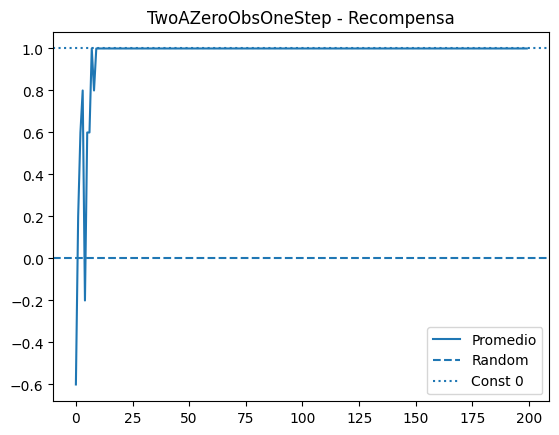

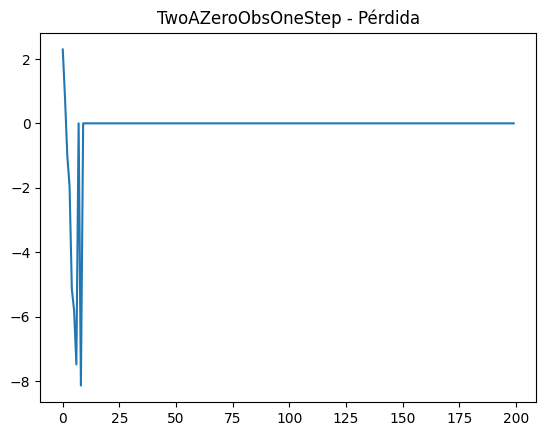

In [25]:
plot_curves(rewards_all, losses_all, rand_ret,const_ret, "TwoAZeroObsOneStep")

## b.TwoARandomObsOneStep

In [26]:
# 1) Crear el entorno
env = TwoARandomObsOneStep()

# 2) Crear la política
# Input_dim = 1 (porque la observación es un escalar)
# Output_dim = env.action_space.n (dos acciones posibles)
policy = Policy(input_dim=1, output_dim=env.action_space.n)

# 3) Crear el optimizador
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

# 4) Entrenar
rewards_all, losses_all = train_loop(
    env=env,
    policy=policy,
    optimizer=optimizer,
    n_batches=200,           # cantidad de batches
    batch_size=10,           # episodios por batch
    gamma=0.99,
    env_name="TwoARandomObsOneStep"
)


TwoARandomObsOneStep | batch 20, avg reward 1.00
TwoARandomObsOneStep | batch 40, avg reward 1.00
TwoARandomObsOneStep | batch 60, avg reward 1.00
TwoARandomObsOneStep | batch 80, avg reward 1.00
TwoARandomObsOneStep | batch 100, avg reward 1.00
TwoARandomObsOneStep | batch 120, avg reward 1.00
TwoARandomObsOneStep | batch 140, avg reward 1.00
TwoARandomObsOneStep | batch 160, avg reward 1.00
TwoARandomObsOneStep | batch 180, avg reward 1.00
TwoARandomObsOneStep | batch 200, avg reward 1.00


In [27]:
random_ret = evaluate_baseline(env,200)

In [28]:
const_ret = evaluate_baseline(env,200,0)

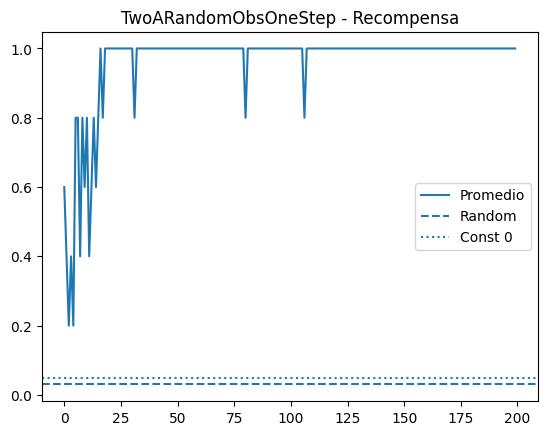

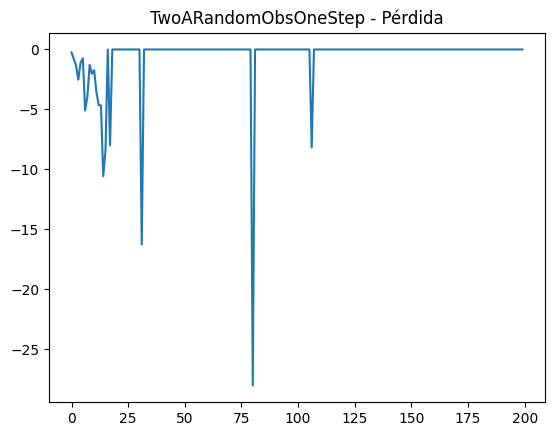

In [29]:
plot_curves(rewards_all, losses_all, random_ret,const_ret, "TwoARandomObsOneStep")

## c.LineWorldEasyEnv

In [30]:
# 1) Crear el entorno
env = LineWorldEasyEnv()

# 2) Crear la política
policy = Policy(input_dim=1, output_dim=env.action_space.n)

# 3) Crear el optimizador
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

# 4) Entrenar
rewards_all, losses_all = train_loop(
    env=env,
    policy=policy,
    optimizer=optimizer,
    n_batches=200,          
    batch_size=10,          
    gamma=0.99,
    env_name="LineWorldEasyEnv"
)


LineWorldEasyEnv | batch 20, avg reward 1.00
LineWorldEasyEnv | batch 40, avg reward 1.00
LineWorldEasyEnv | batch 60, avg reward 1.00
LineWorldEasyEnv | batch 80, avg reward 1.00
LineWorldEasyEnv | batch 100, avg reward 1.00
LineWorldEasyEnv | batch 120, avg reward 1.00
LineWorldEasyEnv | batch 140, avg reward 1.00
LineWorldEasyEnv | batch 160, avg reward 1.00
LineWorldEasyEnv | batch 180, avg reward 1.00
LineWorldEasyEnv | batch 200, avg reward 1.00


In [31]:
random_ret = evaluate_baseline(env,200)

In [32]:
const_ret = evaluate_baseline(env,200,1)

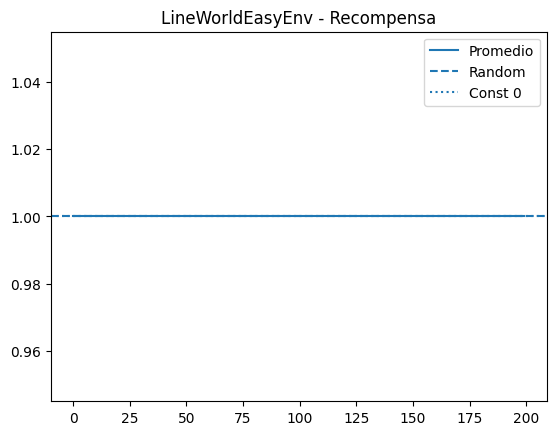

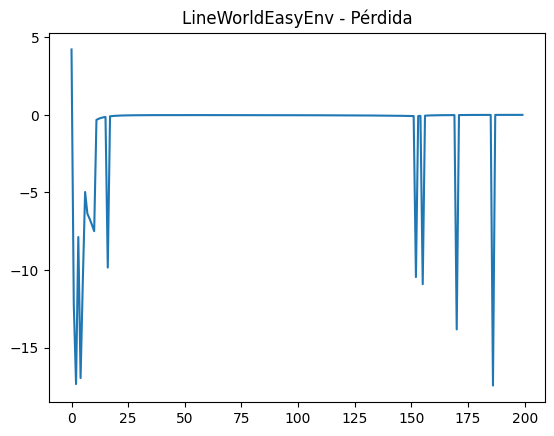

In [33]:
plot_curves(rewards_all, losses_all, random_ret,const_ret, "LineWorldEasyEnv")

## d.LineWorldMirrorEnv

In [34]:
# 1) Crear el entorno
env = LineWorldMirrorEnv()

# 2) Crear la política
policy = Policy(input_dim=1, output_dim=env.action_space.n)

# 3) Crear el optimizador
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

# 4) Entrenar
rewards_all, losses_all = train_loop(
    env=env,
    policy=policy,
    optimizer=optimizer,
    n_batches=200,           # cantidad de batches
    batch_size=10,           # episodios por batch
    gamma=0.99,
    env_name="LineWorldMirrorEnv"
)


LineWorldMirrorEnv | batch 20, avg reward -6.60
LineWorldMirrorEnv | batch 40, avg reward -4.50
LineWorldMirrorEnv | batch 60, avg reward -4.60
LineWorldMirrorEnv | batch 80, avg reward -3.10
LineWorldMirrorEnv | batch 100, avg reward -3.00
LineWorldMirrorEnv | batch 120, avg reward -3.30
LineWorldMirrorEnv | batch 140, avg reward -3.00
LineWorldMirrorEnv | batch 160, avg reward -3.00
LineWorldMirrorEnv | batch 180, avg reward -3.00
LineWorldMirrorEnv | batch 200, avg reward -3.00


In [35]:
random_ret = evaluate_baseline(env,200)

en este ambiente no es posible tomar siempre la misma acción ya que queda en un bucle

In [36]:
const_ret = evaluate_baseline(env,200,0)

KeyboardInterrupt: 

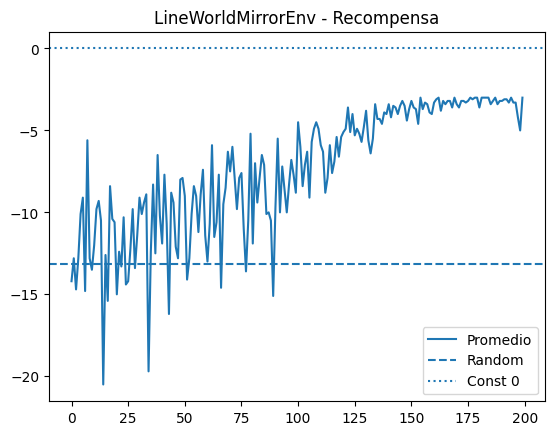

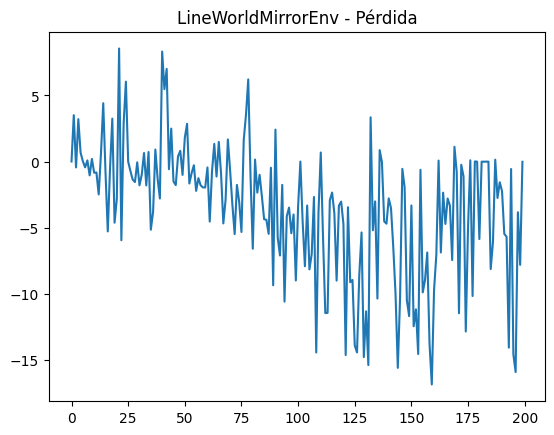

In [ ]:
plot_curves(rewards_all, losses_all, random_ret,0, "LineWorldMirrorEnv")

## e.CartPole-v1

In [ ]:

env = gym.make("CartPole-v1")
policy = Policy(input_dim=env.observation_space.shape[0],
                output_dim=env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

rewards_all, losses_all = train_loop(
    env=env,
    policy=policy,
    optimizer=optimizer,
    n_batches=200,
    batch_size=10,
    gamma=0.99,
    env_name="CartPole-v1"
)

/tmp/ipykernel_3662/3735482472.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state_t = torch.tensor([[state]], dtype=torch.float32)  # 👈 ahora es (1,1)


CartPole-v1 | batch 20, avg reward 30.10
CartPole-v1 | batch 40, avg reward 29.80
CartPole-v1 | batch 60, avg reward 46.80
CartPole-v1 | batch 80, avg reward 60.50
CartPole-v1 | batch 100, avg reward 10.90
CartPole-v1 | batch 120, avg reward 11.40
CartPole-v1 | batch 140, avg reward 14.40
CartPole-v1 | batch 160, avg reward 20.70
CartPole-v1 | batch 180, avg reward 33.60
CartPole-v1 | batch 200, avg reward 27.90


In [ ]:
random_ret = evaluate_baseline(env,200)

In [ ]:
const_ret = evaluate_baseline(env,200,0)

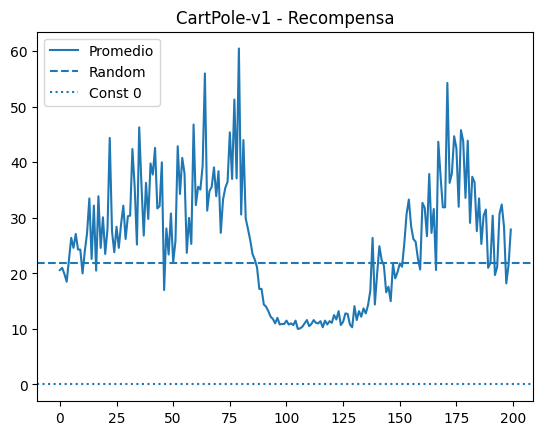

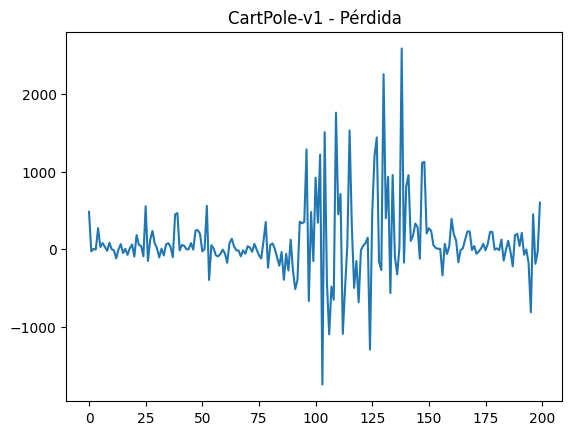

In [ ]:
plot_curves(rewards_all, losses_all, random_ret,0, "CartPole-v1")

In [ ]:

env = gym.make("Acrobot-v1")
policy = Policy(input_dim=env.observation_space.shape[0],
                output_dim=env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

rewards_all, losses_all = train_loop(
    env=env,
    policy=policy,
    optimizer=optimizer,
    n_batches=200,
    batch_size=10,
    gamma=0.99,
    env_name="Acrobot-v1"
)

Acrobot-v1 | batch 20, avg reward -494.50
Acrobot-v1 | batch 40, avg reward -496.10
Acrobot-v1 | batch 60, avg reward -500.00
Acrobot-v1 | batch 80, avg reward -500.00
Acrobot-v1 | batch 100, avg reward -500.00
Acrobot-v1 | batch 120, avg reward -500.00
Acrobot-v1 | batch 140, avg reward -500.00
Acrobot-v1 | batch 160, avg reward -500.00
Acrobot-v1 | batch 180, avg reward -500.00
Acrobot-v1 | batch 200, avg reward -500.00


In [ ]:
random_ret = evaluate_baseline(env,200)

In [ ]:
const_ret = evaluate_baseline(env,200,0)

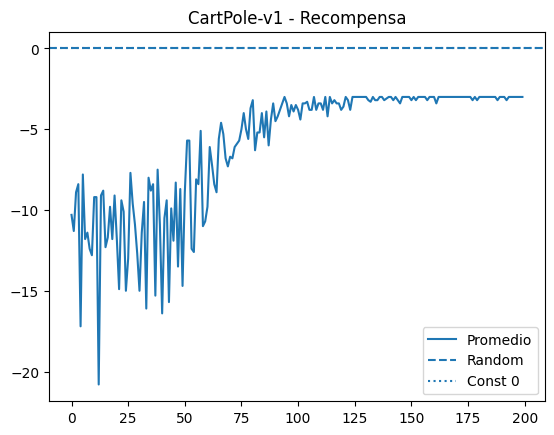

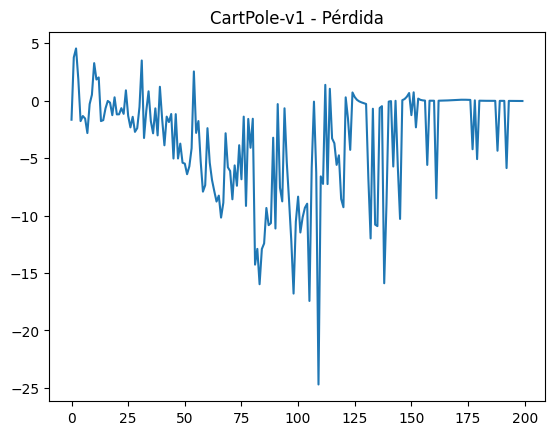

In [ ]:
plot_curves(rewards_all, losses_all, 0,0, "Acrobot-v1")

# 4. Reinforce con baseline

In [47]:
# Definir red de valor (muy simple)
class ValueNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)



In [48]:
def reinforce_baseline(env, policy, value_net, policy_optimizer, value_optimizer,
                            batch_size=10, gamma=0.99):
    all_rewards = []

    batch_obs, batch_acts, batch_returns = [], [], []

    for episode in range(batch_size):
        state, _ = env.reset()
        rewards, states, actions = [], [], []

        done = False
        while not done:
            state_t = torch.tensor([[state]], dtype=torch.float32)
            dist = get_policy(state_t, policy)
            action = dist.sample()
            
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            states.append(state_t)
            actions.append(action.item())
            rewards.append(reward)
            state = next_state

        discounted = compute_returns(rewards, gamma)
        batch_obs.extend(states)
        batch_acts.extend(actions)
        batch_returns.extend(discounted)
        all_rewards.append(sum(rewards))

    batch_obs = torch.cat(batch_obs, dim=0)
    batch_acts = torch.tensor(batch_acts, dtype=torch.int64)
    batch_returns = torch.tensor(batch_returns, dtype=torch.float32)

    # normalizar retornos
    batch_returns = (batch_returns - batch_returns.mean()) / (batch_returns.std() + 1e-8)

    # 1) Calcular ventaja
    with torch.no_grad():
        baseline = value_net(batch_obs).squeeze()
    advantages = batch_returns - baseline

    # 2) Pérdida de política
    dist = get_policy(batch_obs, policy)
    log_probs = dist.log_prob(batch_acts)
    policy_loss = -(log_probs * advantages).sum()

    # 3) Pérdida de baseline (MSE)
    value_loss = F.mse_loss(value_net(batch_obs).squeeze(), batch_returns)

    # 4) Optimización
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    return all_rewards, policy_loss.item(), value_loss.item()


In [51]:
def train_loop_baseline(env, policy, value_net, policy_optimizer, value_optimizer,
                        n_batches=300, batch_size=10, gamma=0.99, env_name="env_baseline"):
    writer = SummaryWriter(log_dir=f"runs/{env_name}")
    rewards_all, policy_losses, value_losses = [], [], []

    for batch in range(1, n_batches+1):
        rewards, policy_loss, value_loss = reinforce_baseline(
            env, policy, value_net, policy_optimizer, value_optimizer,
            batch_size=batch_size, gamma=gamma
        )

        avg_reward = np.mean(rewards)

        rewards_all.append(avg_reward)
        policy_losses.append(policy_loss)
        value_losses.append(value_loss)

        # log a TensorBoard
        writer.add_scalar("reward/avg", avg_reward, batch)
        writer.add_scalar("loss/policy", policy_loss, batch)
        writer.add_scalar("loss/value", value_loss, batch)

        if batch % 20 == 0:
            print(f"{env_name} | batch {batch}, avg reward {avg_reward:.2f}, "
                  f"policy_loss {policy_loss:.3f}, value_loss {value_loss:.3f}")

    writer.close()
    return rewards_all, policy_losses, value_losses


In [ ]:
env = gym.make("CartPole-v1")

# Red de política (ya la tenés definida como `Policy`)
policy = Policy(env.observation_space.shape[0], env.action_space.n)

# Red de valor
value_net = ValueNet(env.observation_space.shape[0])

# Optimizadores
policy_optimizer = optim.Adam(policy.parameters(), lr=1e-2)
value_optimizer = optim.Adam(value_net.parameters(), lr=1e-2)

# Entrenamiento
rewards_all, policy_losses, value_losses = train_loop_baseline(
    env=env,
    policy=policy,
    value_net=value_net,
    policy_optimizer=policy_optimizer,
    value_optimizer=value_optimizer,
    n_batches=300,
    batch_size=10,
    gamma=0.99,
    env_name="CartPole-v1_baseline"
)


CartPole-v1_baseline | batch 20, avg reward 28.90, policy_loss 789.079, value_loss 0.790
CartPole-v1_baseline | batch 40, avg reward 25.70, policy_loss 684.533, value_loss 0.744
CartPole-v1_baseline | batch 60, avg reward 69.50, policy_loss 40433.500, value_loss 0.860
CartPole-v1_baseline | batch 80, avg reward 19.90, policy_loss 1519.345, value_loss 0.589
CartPole-v1_baseline | batch 100, avg reward 31.20, policy_loss -1812.785, value_loss 0.663
CartPole-v1_baseline | batch 120, avg reward 23.30, policy_loss 3236.838, value_loss 0.653
CartPole-v1_baseline | batch 140, avg reward 76.00, policy_loss 217594.344, value_loss 0.744
CartPole-v1_baseline | batch 160, avg reward 22.80, policy_loss -1967.526, value_loss 0.554
CartPole-v1_baseline | batch 180, avg reward 25.10, policy_loss 4913.671, value_loss 0.720
CartPole-v1_baseline | batch 200, avg reward 26.40, policy_loss 4125.606, value_loss 0.577
CartPole-v1_baseline | batch 220, avg reward 33.40, policy_loss 8044.730, value_loss 0.468


In [ ]:
import gym
import torch
import torch.optim as optim

# Crear el entorno Acrobot
env = gym.make("Acrobot-v1")

# Red de política
policy = Policy(env.observation_space.shape[0], env.action_space.n)

# Red de valor
value_net = ValueNet(env.observation_space.shape[0])

# Optimizadores
policy_optimizer = optim.Adam(policy.parameters(), lr=1e-2)
value_optimizer = optim.Adam(value_net.parameters(), lr=1e-2)

# Entrenamiento
rewards_all, policy_losses, value_losses = train_loop_baseline(
    env=env,
    policy=policy,
    value_net=value_net,
    policy_optimizer=policy_optimizer,
    value_optimizer=value_optimizer,
    n_batches=300,
    batch_size=10,
    gamma=0.99,
    env_name="Acrobot-v1_baseline"
)
